In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

import play_song as song
import feature_selection as fs
import NA_outliers as n

In [104]:
df = pd.read_csv('./project_data/out_eda1.csv', 
                 index_col = 'Claim Identifier')

#df.head()

In [97]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def ball_tree_impute(df, target, n_neighbors=5):
    # Get all features except the target column
    features = df.columns.drop(target)
    
    # Separate rows with and without missing target values
    missing_mask = df[target].isna()
    non_missing_data = df[~missing_mask]
    missing_data = df[missing_mask]

    # Build a ball tree using all features except the target column
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
    knn.fit(non_missing_data[features])

    # Find nearest neighbors for rows with missing values
    _, indices = knn.kneighbors(missing_data[features])

     # Initialize a Series to store imputed values
    imputed_values = pd.Series(index=df.index)

    # Impute missing values by averaging the target values of nearest neighbors
    for i, neighbor_indices in enumerate(indices):
        # Calculate the mean of the neighbors' target values
        mean_value = non_missing_data.iloc[neighbor_indices][target].mean()
        imputed_values[missing_data.index[i]] = mean_value

    # Combine the imputed values with the original target values
    result = df[target].combine_first(imputed_values)

    return result


def log_transform(X):
    return np.where(X > 0, np.log1p(X), X)

In [99]:
def custom_impute(df):
      
    for var_name in df.columns:
        
        if any(word in var_name for word in ['Year', 'Month', 'Day']) and var_name != 'Birth Year':
                df[var_name] = df[var_name].fillna(df[var_name].median())
        
        if var_name == 'Birth Year':
            # Only perform imputation for rows where both columns are not NaN and Birth Year is NaN or 0
            mask = df['Accident Year'].notna() & df['Age at Injury'].notna()
            df.loc[mask & (df['Birth Year'].isna() | (df['Birth Year'] == 0)), 
                    'Birth Year'] = df['Accident Year'] - df['Age at Injury']

            remaining_nans = df['Birth Year'].isna().sum()
            if remaining_nans > 0:
                median = df[var_name].median()
                df[var_name] = df[var_name].fillna(median)

        
        # Zip Code
        if var_name == 'Zip Code':
            df['Zip Code'] = df['Zip Code'].fillna(99999)

        # for all 'code' variables  
        if 'Code' in var_name and var_name != 'Zip Code':
            code_columns = df.filter(regex='Code$', axis=1).columns
            df[code_columns] = df[code_columns].fillna(0)

    
    df['Average Weekly Wage'] = ball_tree_impute(df, 'Average Weekly Wage')
          
    return df

In [100]:
custom_impute(df)

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year,Accident Month,Accident Day,Assembly Year,Assembly Month,Assembly Day,C-2 Year,C-2 Month,C-2 Day,C-3 Date Binary,First Hearing Year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,571411.0,0.0,0.000,1988.0,12736.0,285367.0,2,3355.0,0.0,44646.0,0.0,0.0,44.0,135885.0,27.0,10.0,62.0,13662.0,1.0,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,0,0
5393091,46.0,571411.0,1.0,1745.930,1973.0,2862.0,285367.0,4,760.0,0.0,40449.0,1.0,4.0,23.0,135885.0,97.0,49.0,38.0,14569.0,4.0,2019.0,8.0,30.0,2020,1,1,2020.0,1.0,1.0,1,2020
5393889,40.0,571411.0,0.0,1434.800,1979.0,9126.0,285367.0,4,17450.0,0.0,86171.0,0.0,0.0,56.0,85033.0,79.0,7.0,10.0,12589.0,6.0,2019.0,12.0,6.0,2020,1,1,2020.0,1.0,1.0,0,0
5393887,61.0,571411.0,0.0,325.484,1958.0,111144.0,111144.0,2,11530.0,0.0,86171.0,0.0,0.0,62.0,85033.0,16.0,43.0,36.0,12603.0,1.0,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,0,0
5393863,67.0,571411.0,0.0,0.000,1952.0,14366.0,285367.0,3,60430.0,0.0,60536.0,0.0,0.0,44.0,265981.0,31.0,10.0,38.0,11772.0,5.0,2019.0,12.0,26.0,2020,1,1,2019.0,12.0,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165265,35.0,571411.0,0.0,0.000,1987.0,111144.0,111144.0,2,39618.0,0.0,270778.0,0.0,0.0,56.0,265981.0,45.0,10.0,42.0,10467.0,4.0,2022.0,12.0,14.0,2022,12,30,2022.0,12.0,30.0,0,0
6165285,33.0,571411.0,0.0,0.000,1989.0,2331.0,285367.0,2,43580.0,0.0,270778.0,0.0,0.0,62.0,265981.0,74.0,37.0,35.0,11590.0,6.0,2022.0,12.0,15.0,2022,12,31,2022.0,12.0,31.0,0,0
6165506,61.0,571411.0,0.0,991.080,1961.0,2950.0,285367.0,4,30874.0,0.0,45605.0,1.0,1.0,62.0,85033.0,98.0,80.0,34.0,14227.0,3.0,2022.0,12.0,13.0,2022,12,31,2022.0,12.0,31.0,0,0


In [66]:
## EVAL function

In [105]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Year', 'Accident Month', 'Accident Day', 'Assembly Year', 'Assembly Month', 'Assembly Day',
       'C-2 Year', 'C-2 Month', 'C-2 Day', 'First Hearing Year']

categ = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type',
         'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
         'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Zip Code', 'C-3 Date Binary' ]

In [138]:
from sklearn.metrics import classification_report
from collections import Counter
import time
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial
from sklearn.preprocessing import RobustScaler


def evaluate_features(df, num, categ, 
                      rfe_features, rfe_model, k=5):
    
    start_time = time.time()
    
    X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']
    kf = KFold(n_splits=k)
    selected_features = []

    for train_idx, val_idx in kf.split(X):
        
        print(f'------------ FOLD ------------ \n')
        start_time = time.time()
        
        ### SPLIT
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        original_columns = X_train.columns
        
        ### PIPELINE
        
        pipeline = Pipeline([
        ('imputer', FunctionTransformer(custom_impute, validate=False)), 
        ('log_transform', FunctionTransformer(log_transform, validate=False)),  
        ('scaler', RobustScaler()),
        ])
        
        X_train = pipeline.fit_transform(X_train, y_train)
        X_val = pipeline.transform(X_val)
        X_train = pd.DataFrame(X_train, columns=original_columns)
        X_val = pd.DataFrame(X_val, columns=original_columns)

        
        ### FEATURE SELECTION
        # Numerical
        print('----LASSO----')
        lasso = fs.lasso(X_train, y_train, num)
        print('----RFE----')
        # for model in rfe_model: ## FUTURE
        rfe = fs.rfe(X_train, y_train, num, rfe_features, rfe_model)
        print('----CORR----')
        corr = fs.correlation_matrix(X_train, num)
        #print('----VAR----')
        var = fs.var(X_train, num)
        
        # Categorical
        print('----CHI2----')
        chi2 = fs.chi_squared(X_train, y_train, categ)
        print('----MI----')
        mutual_information = fs.mutual_information(X_train, y_train, categ)
        
        ### COMBINTE FEATURE SELECTION
        num_selected = set(lasso).union(rfe, corr, var)
        categ_selected = set(chi2).union(mutual_information)
        num_selected = [feature for feature in num_selected if isinstance(feature, str)]
        categ_selected = list(categ_selected)
        
        ### SELECT COLUMNS FROM DATAFRAMES
        X_train_selected = X_train[num_selected + categ_selected]
        X_val_selected = X_val[num_selected + categ_selected]


        ### PREDICTIONS
        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val_selected)
        
        # Print classification report for current fold
        print('CLASSIFICATION REPORT \n')
        print(classification_report(y_val, y_pred))

        # Save selected features for counting occurrences
        selected_features.append(num_selected + categ_selected)

        # End timing
        end_time1 = time.time()
        elapsed_time1 = (end_time1 - start_time) / 60
        print(elapsed_time1)
    
    # Count occurrences of each feature across folds
    feature_counts = Counter(np.concatenate(selected_features))
    
    song.play_('audio.mp3')
    # End timing
    end_time2 = time.time()
    elapsed_time2 = (end_time2 - start_time) / 60
    print(elapsed_time2)
    
    # Select only features that appear in all folds
    final_features = [feature for feature, count in feature_counts.items() if count == k]
    return final_features


------------ FOLD ------------ 

----LASSO----


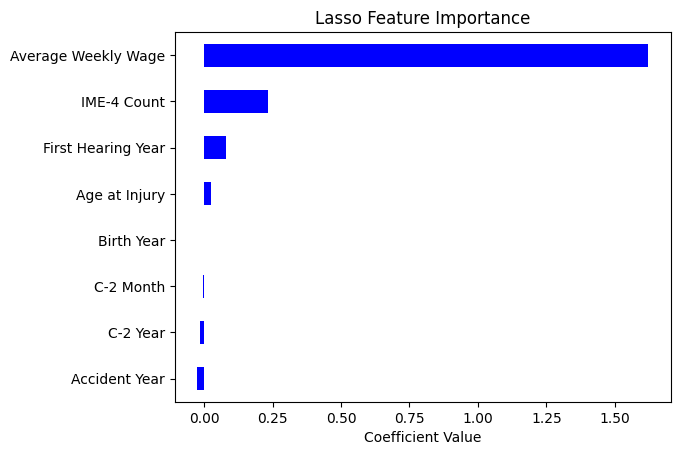

----RFE----
Trying with 15 features: 15 selected features.
Classification Report for 15 features:
              precision    recall  f1-score   support

           1       0.12      0.01      0.01     10012
           2       0.83      0.96      0.89    233963
           3       0.46      0.05      0.08     56841
           4       0.62      0.94      0.75    118981
           5       0.71      0.05      0.10     36183
           6       0.05      0.00      0.00      2864
           7       0.00      0.00      0.00        56
           8       0.00      0.00      0.00       320

    accuracy                           0.74    459220
   macro avg       0.35      0.25      0.23    459220
weighted avg       0.70      0.74      0.67    459220

----CORR----


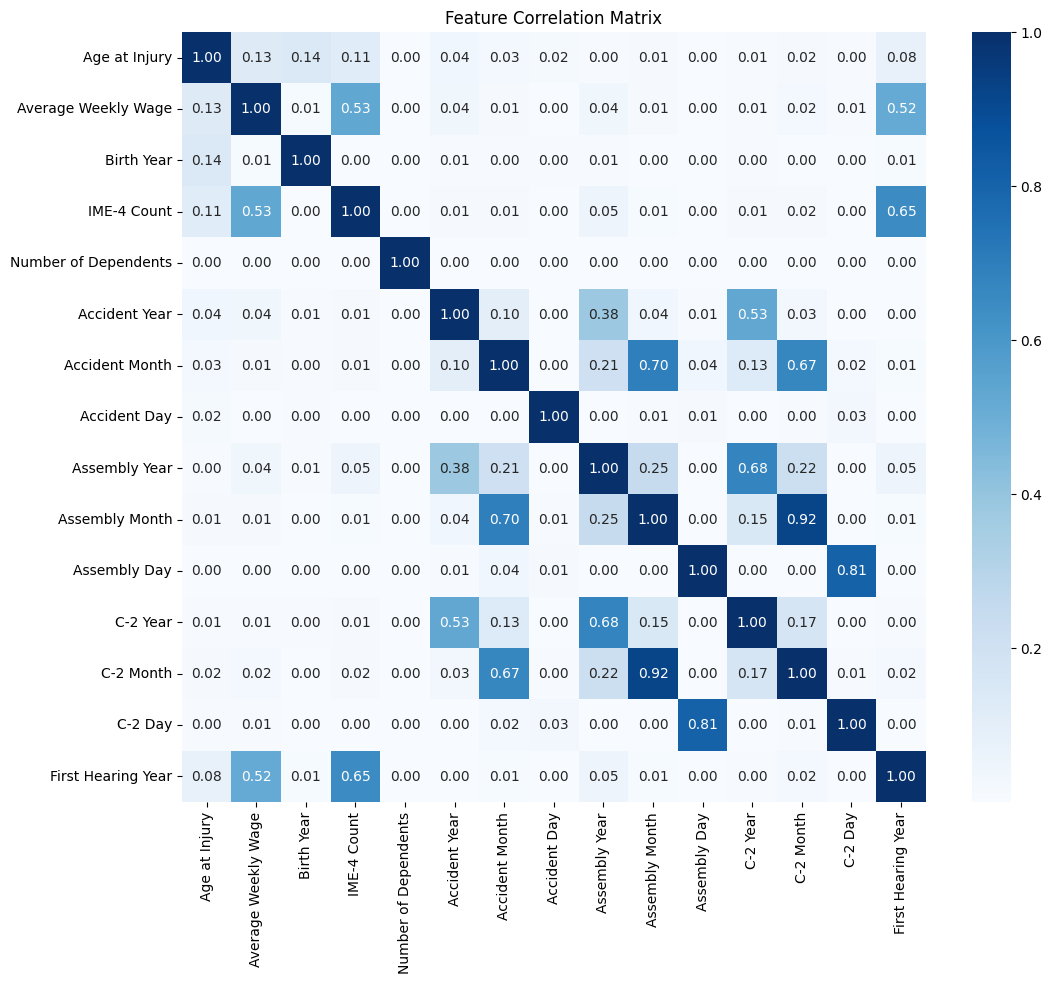

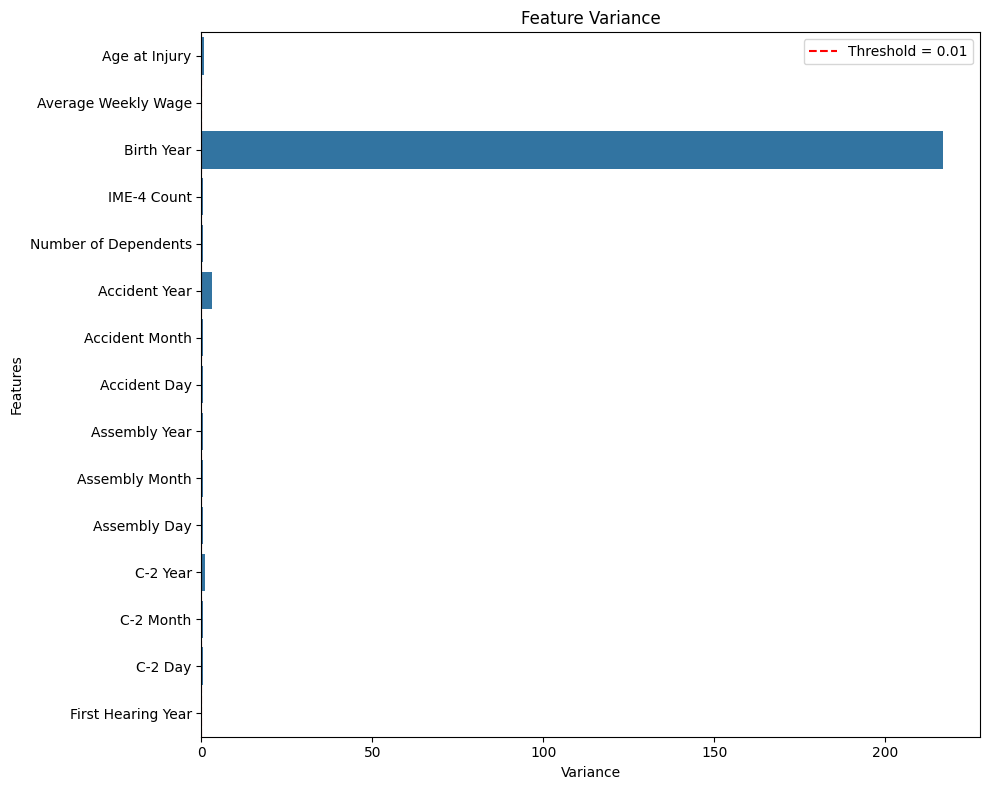

----CHI2----


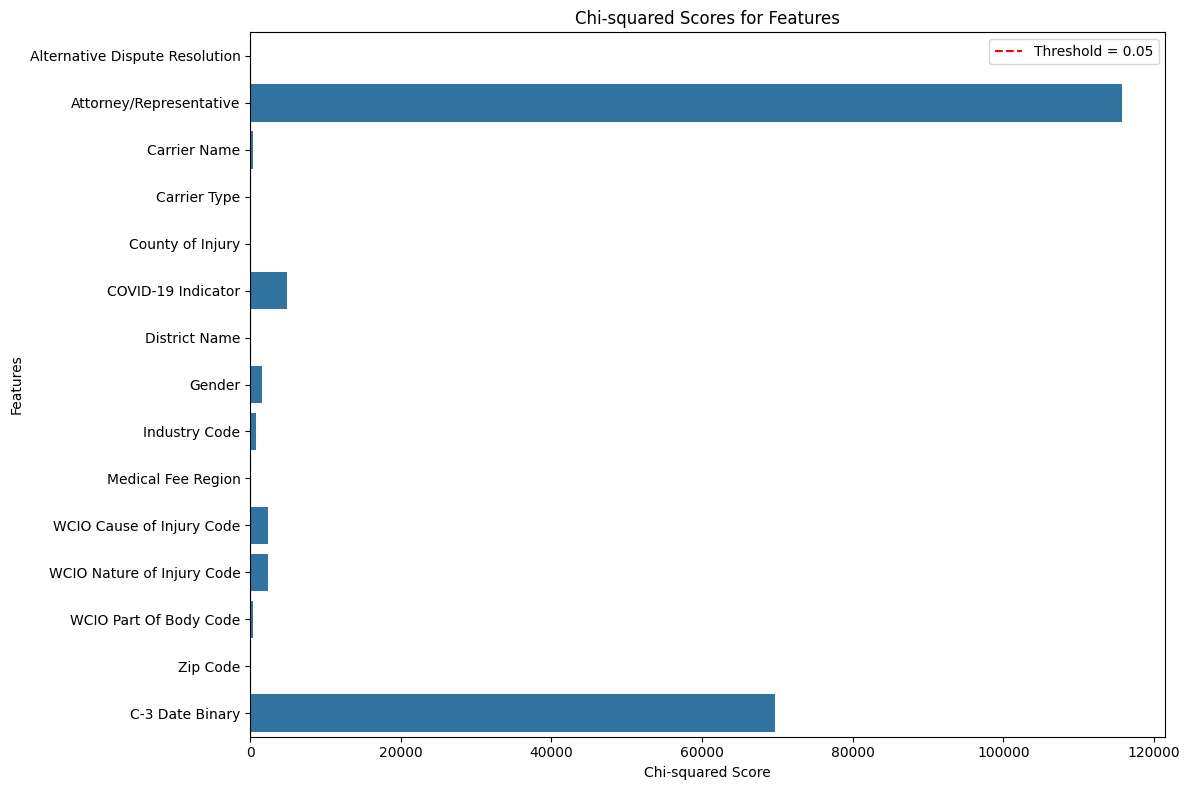

----MI----


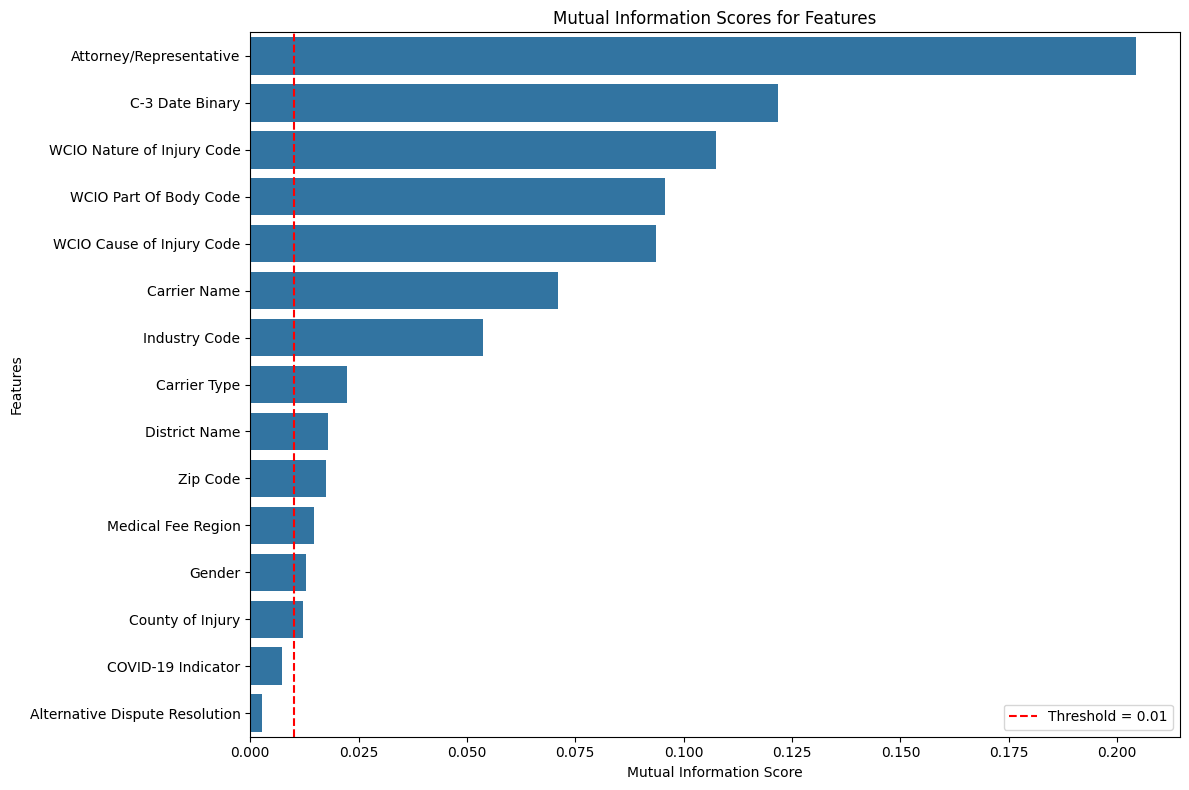

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.46      0.36      0.41      2464
           2       0.84      0.95      0.89     57115
           3       0.35      0.02      0.03     12065
           4       0.64      0.74      0.69     29526
           5       0.47      0.55      0.51     12097
           6       0.00      0.00      0.00      1347
           7       0.00      0.00      0.00        41
           8       0.00      0.00      0.00       150

    accuracy                           0.73    114805
   macro avg       0.35      0.33      0.32    114805
weighted avg       0.68      0.73      0.68    114805

98.78576993942261
------------ FOLD ------------ 

----LASSO----


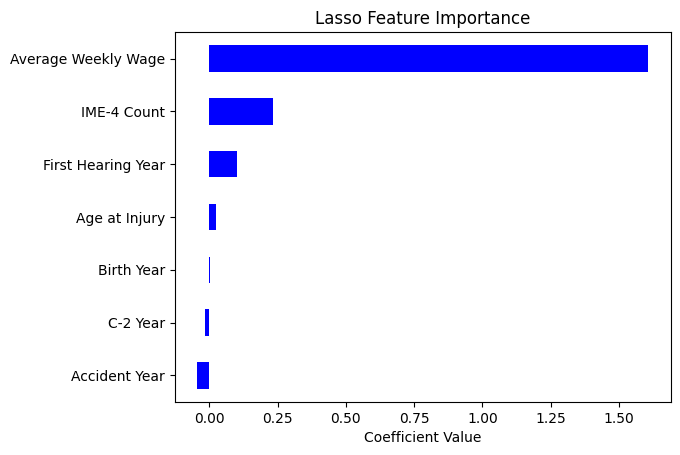

----RFE----
Trying with 15 features: 15 selected features.
Classification Report for 15 features:
              precision    recall  f1-score   support

           1       0.19      0.02      0.03      9996
           2       0.83      0.96      0.89    235065
           3       0.46      0.04      0.07     57168
           4       0.61      0.94      0.74    118019
           5       0.50      0.01      0.02     35560
           6       0.00      0.00      0.00      2998
           7       0.00      0.00      0.00        68
           8       0.00      0.00      0.00       346

    accuracy                           0.74    459220
   macro avg       0.32      0.25      0.22    459220
weighted avg       0.68      0.74      0.66    459220

----CORR----


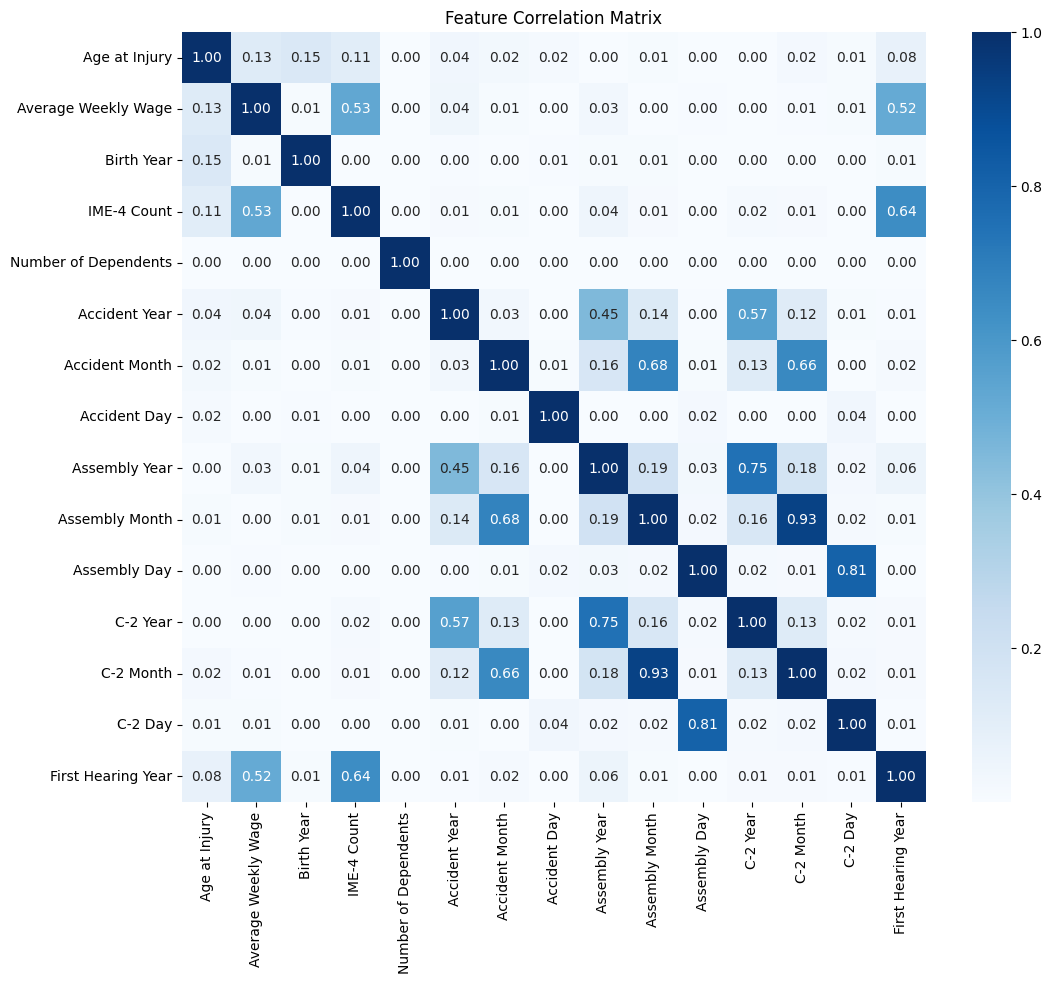

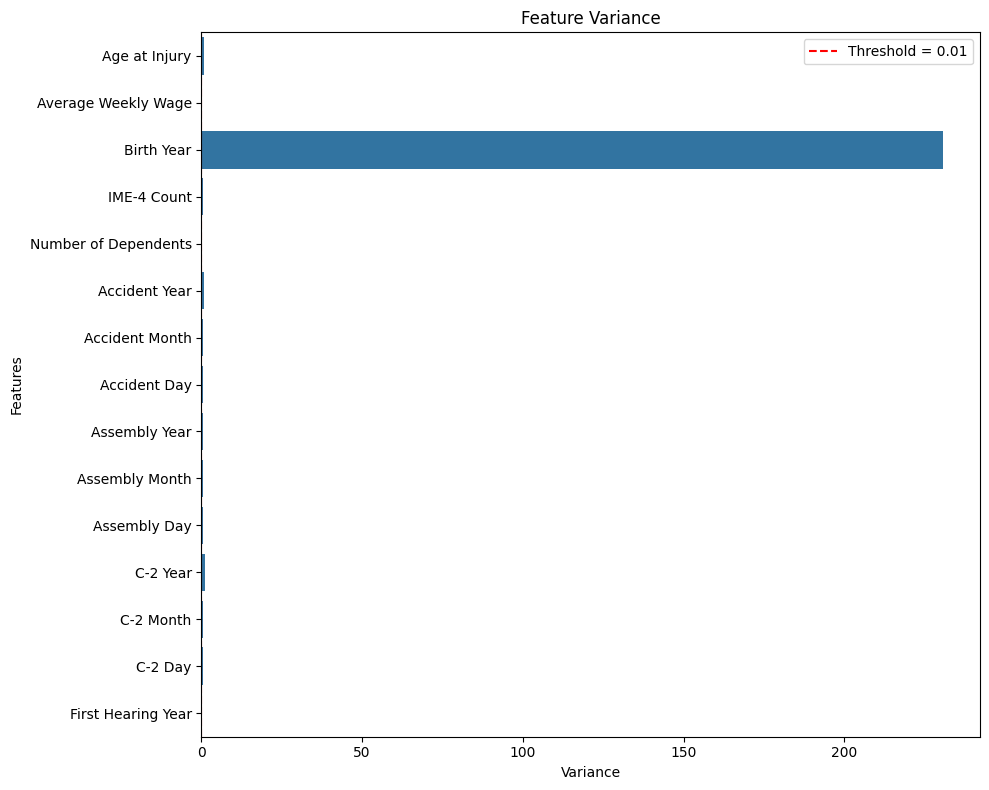

----CHI2----


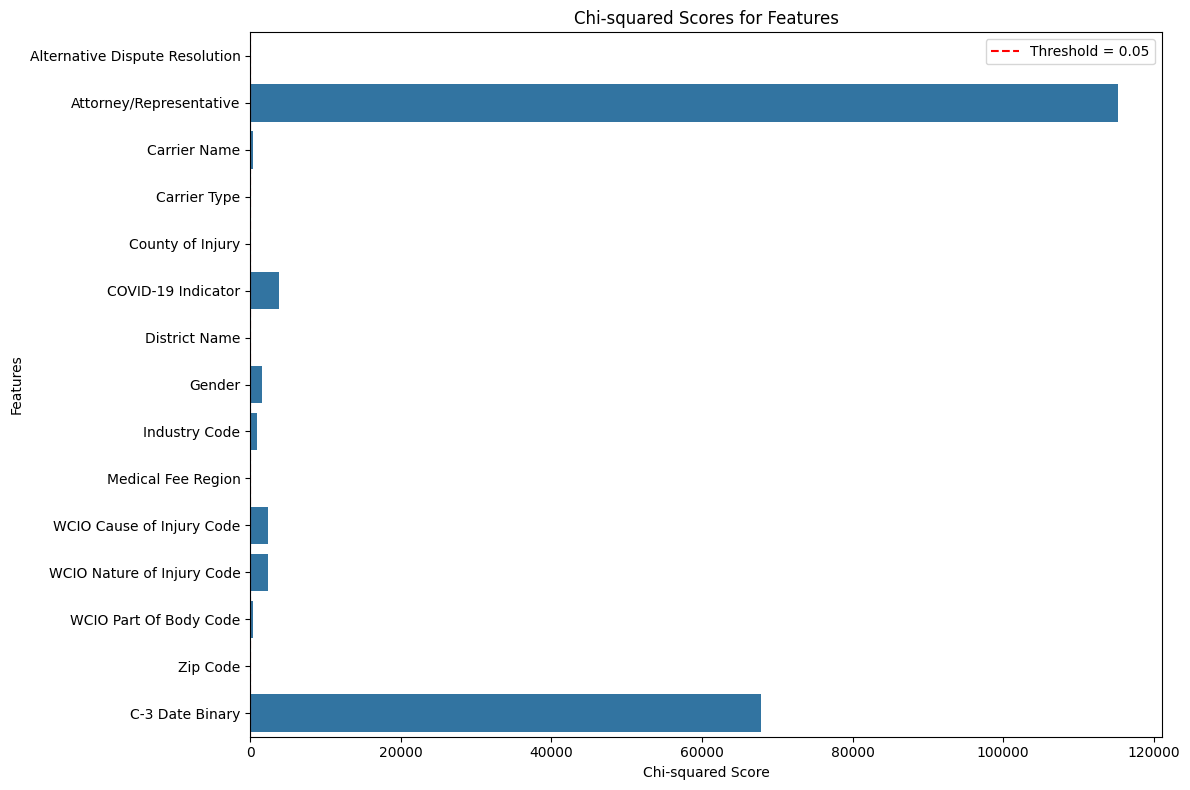

----MI----


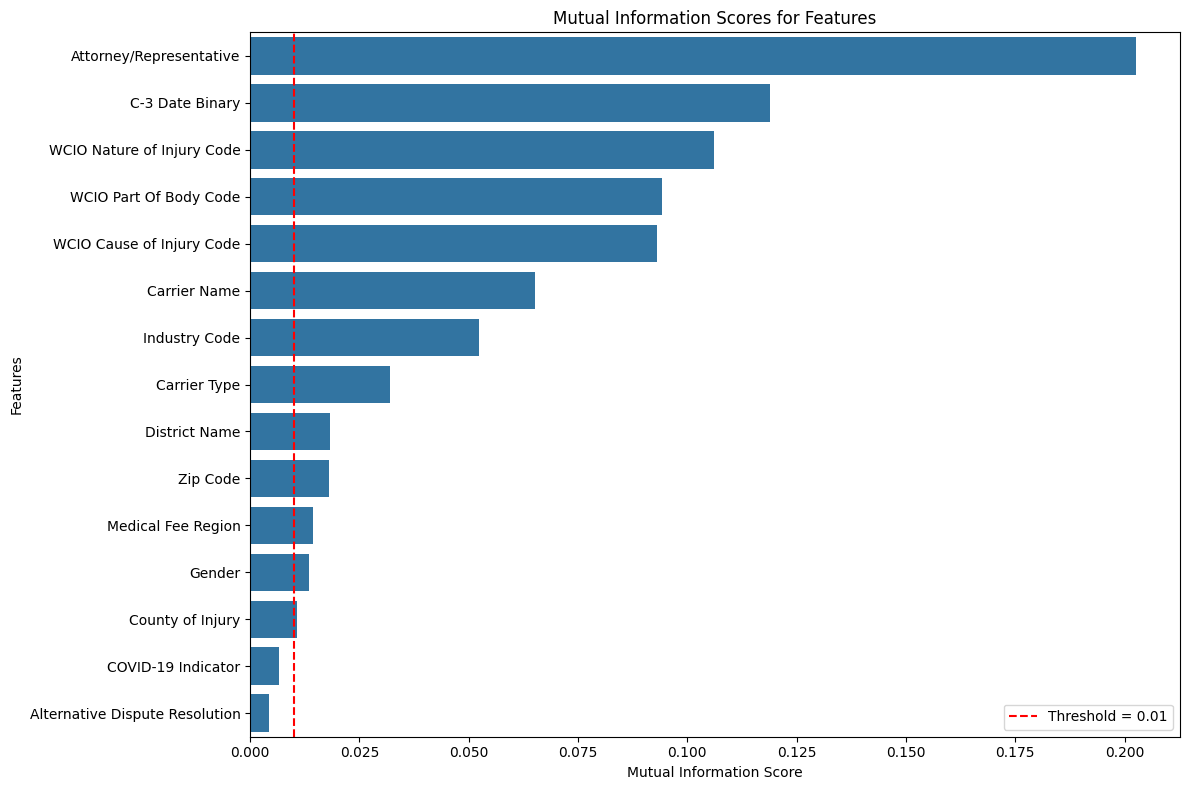

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.59      0.33      0.42      2480
           2       0.85      0.94      0.90     56013
           3       0.32      0.05      0.08     11738
           4       0.61      0.89      0.72     30488
           5       0.61      0.26      0.37     12720
           6       0.00      0.00      0.00      1213
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00       124

    accuracy                           0.74    114805
   macro avg       0.37      0.31      0.31    114805
weighted avg       0.69      0.74      0.69    114805

106.7912380695343
------------ FOLD ------------ 

----LASSO----


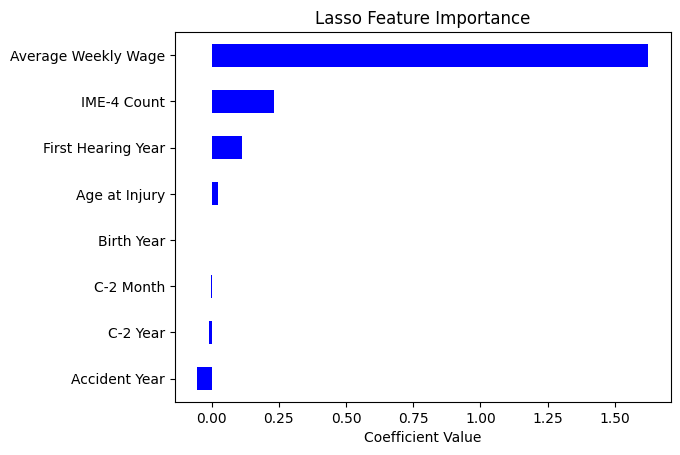

----RFE----
Trying with 15 features: 15 selected features.
Classification Report for 15 features:
              precision    recall  f1-score   support

           1       0.10      0.00      0.01      9917
           2       0.84      0.96      0.89    234612
           3       0.44      0.05      0.08     54499
           4       0.61      0.94      0.74    118895
           5       0.44      0.01      0.01     37541
           6       0.02      0.00      0.00      3288
           7       0.00      0.00      0.00        79
           8       0.00      0.00      0.00       389

    accuracy                           0.74    459220
   macro avg       0.31      0.24      0.22    459220
weighted avg       0.68      0.74      0.66    459220

----CORR----


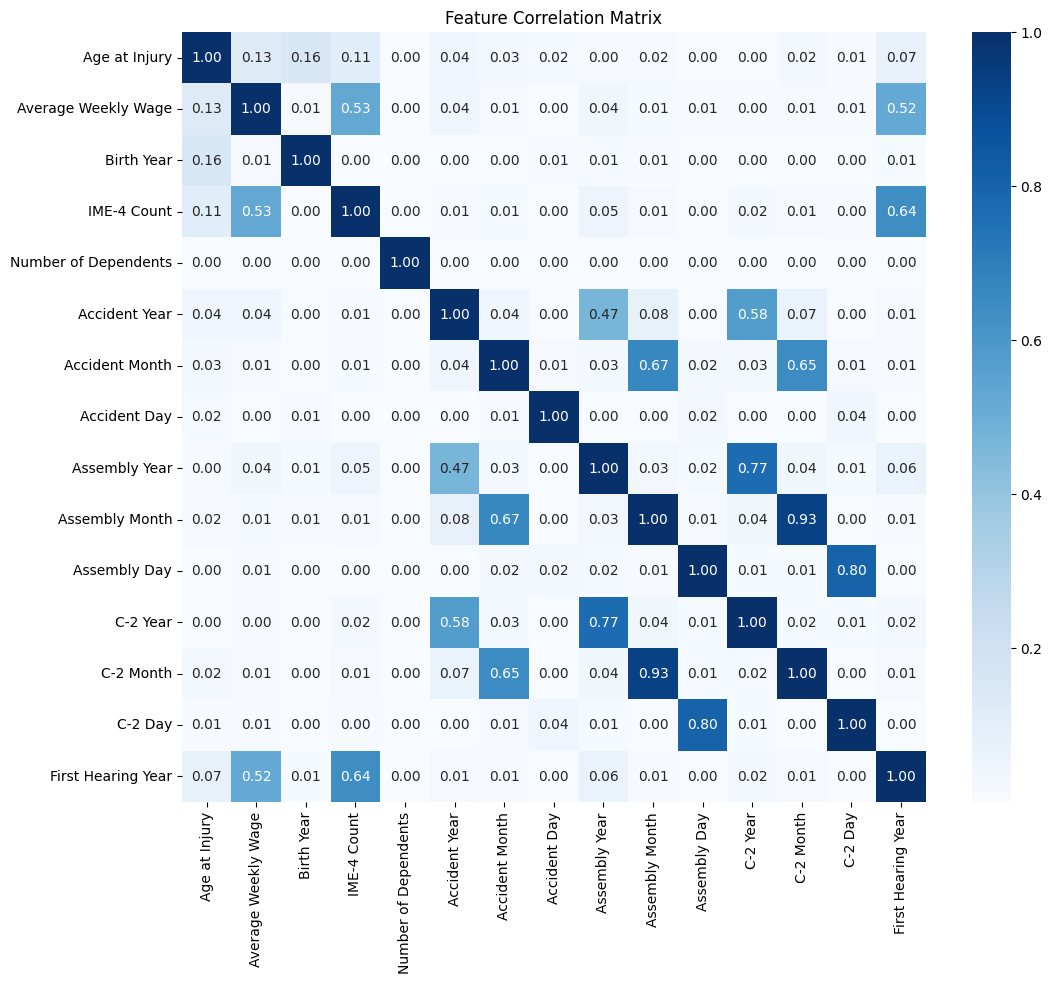

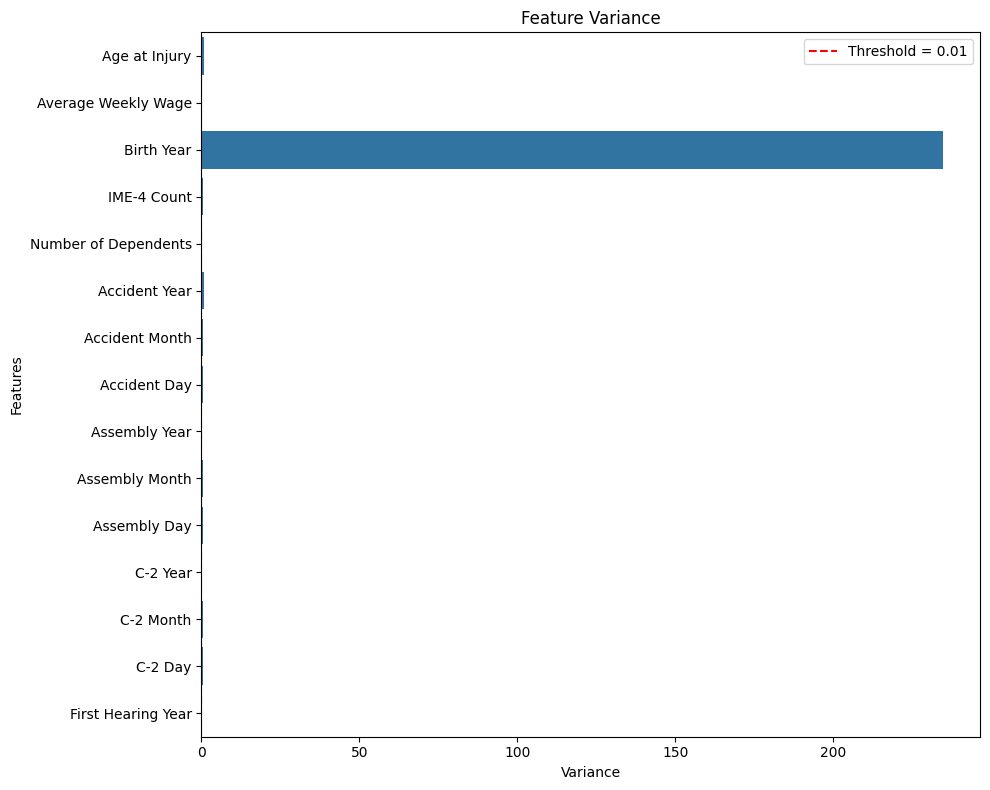

----CHI2----


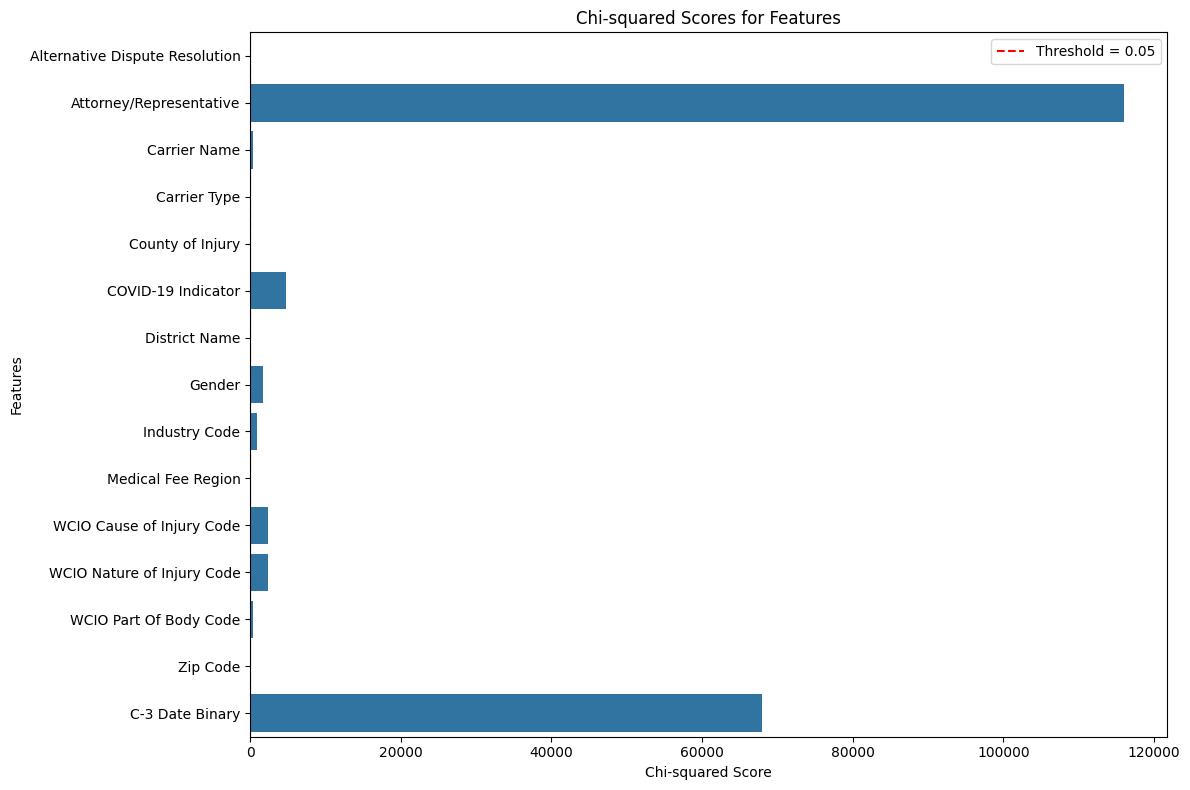

----MI----


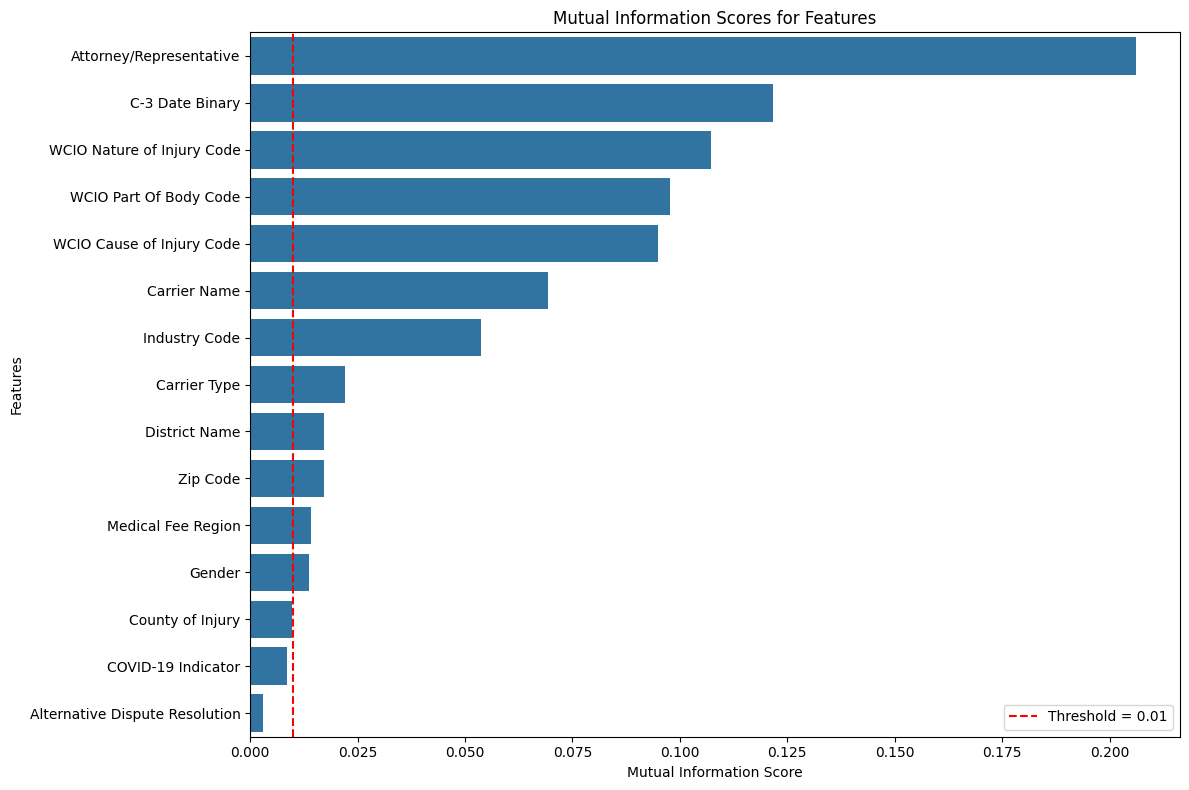

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.64      0.29      0.40      2559
           2       0.83      0.95      0.89     56466
           3       0.40      0.03      0.06     14407
           4       0.61      0.93      0.74     29612
           5       0.68      0.16      0.26     10739
           6       0.04      0.00      0.00       923
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        81

    accuracy                           0.73    114805
   macro avg       0.40      0.30      0.29    114805
weighted avg       0.69      0.73      0.67    114805

113.17149996757507
------------ FOLD ------------ 

----LASSO----


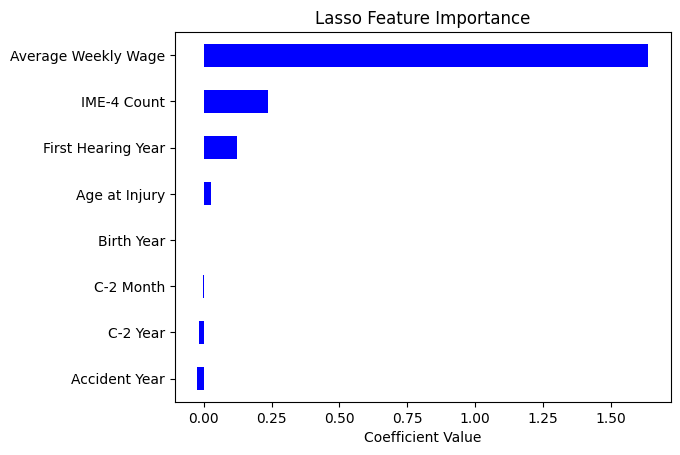

----RFE----
Trying with 15 features: 15 selected features.
Classification Report for 15 features:
              precision    recall  f1-score   support

           1       0.22      0.01      0.02     10039
           2       0.83      0.96      0.89    231317
           3       0.43      0.05      0.08     54357
           4       0.61      0.93      0.74    119013
           5       0.65      0.05      0.10     40317
           6       0.03      0.00      0.00      3688
           7       0.00      0.00      0.00        92
           8       0.00      0.00      0.00       397

    accuracy                           0.74    459220
   macro avg       0.34      0.25      0.23    459220
weighted avg       0.69      0.74      0.66    459220

----CORR----


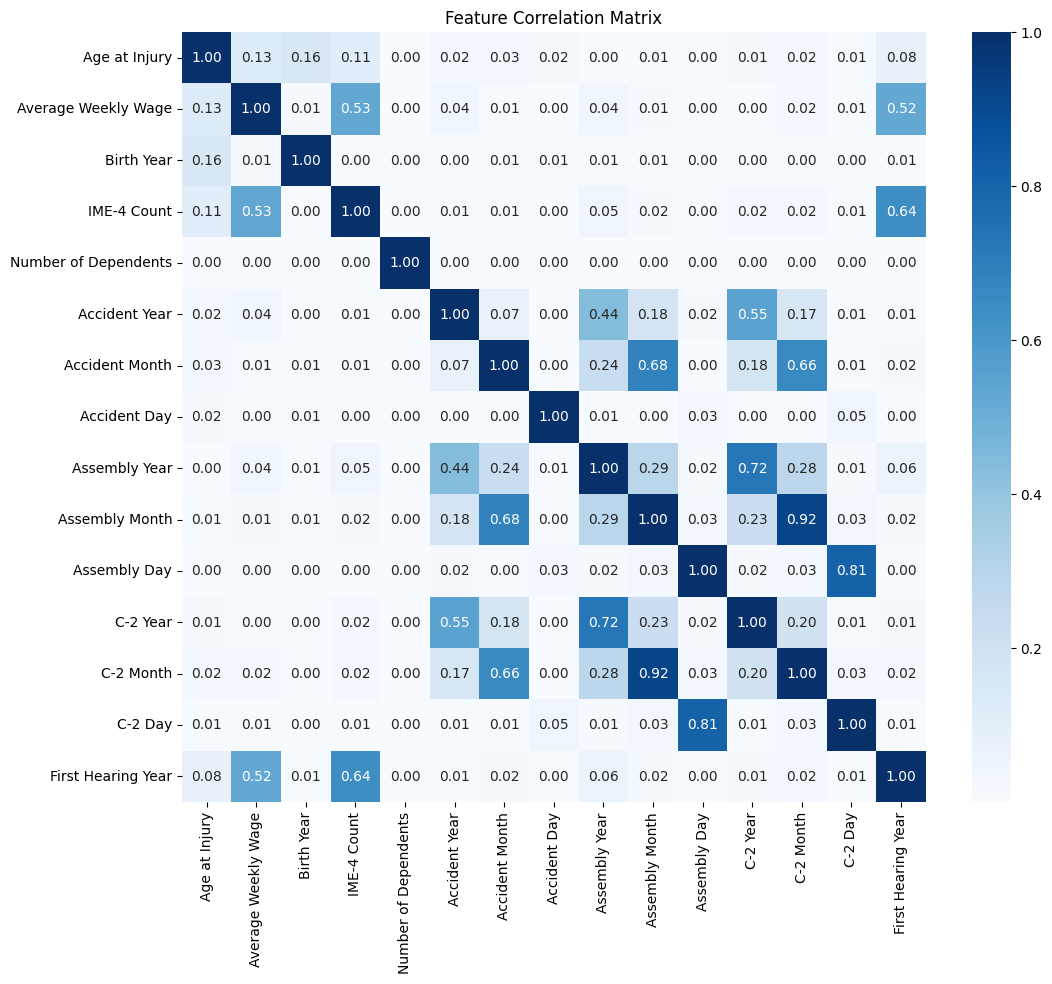

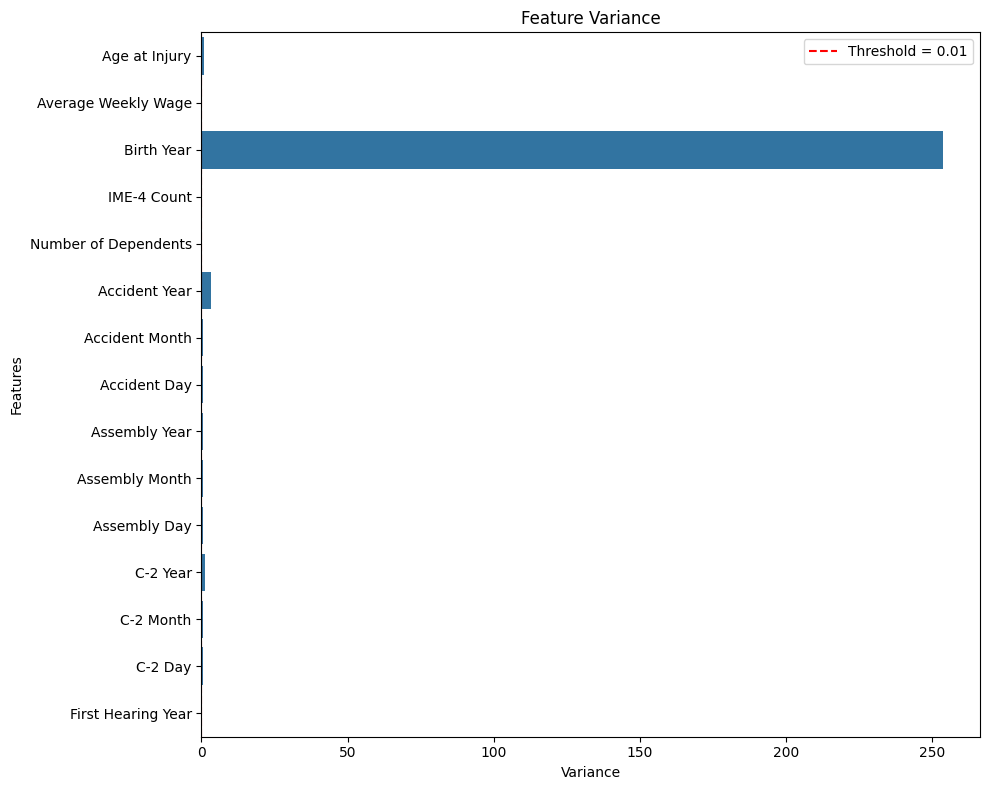

----CHI2----


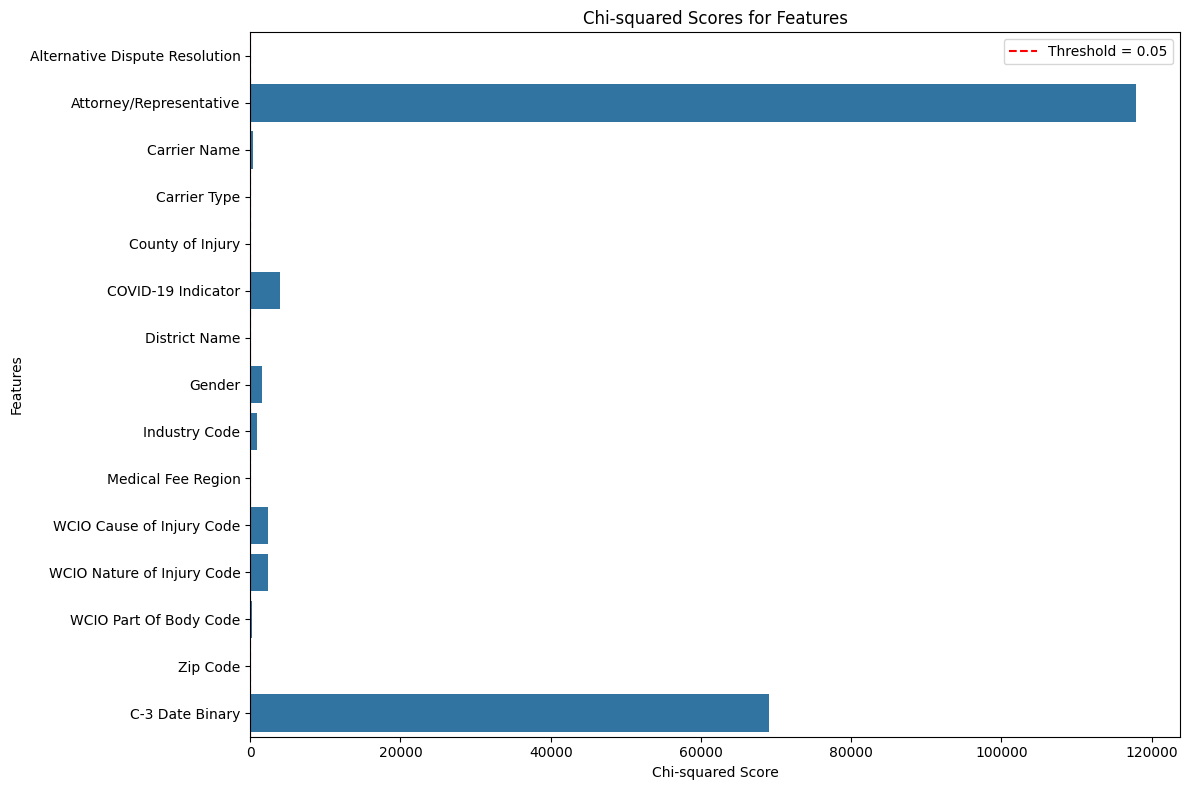

----MI----


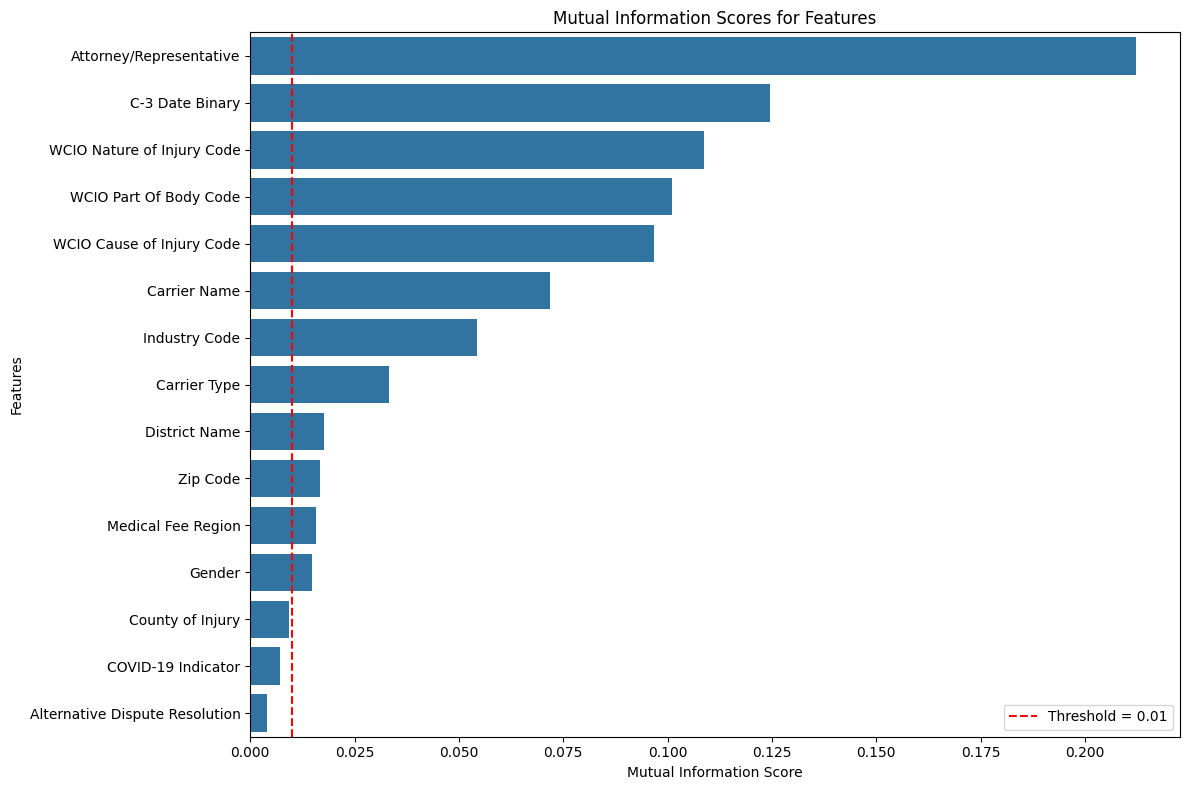

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.65      0.30      0.41      2437
           2       0.85      0.95      0.89     59761
           3       0.40      0.05      0.09     14549
           4       0.64      0.93      0.76     29494
           5       0.56      0.10      0.17      7963
           6       0.00      0.00      0.00       523
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        73

    accuracy                           0.75    114805
   macro avg       0.39      0.29      0.29    114805
weighted avg       0.71      0.75      0.69    114805

115.41992807388306
------------ FOLD ------------ 

----LASSO----


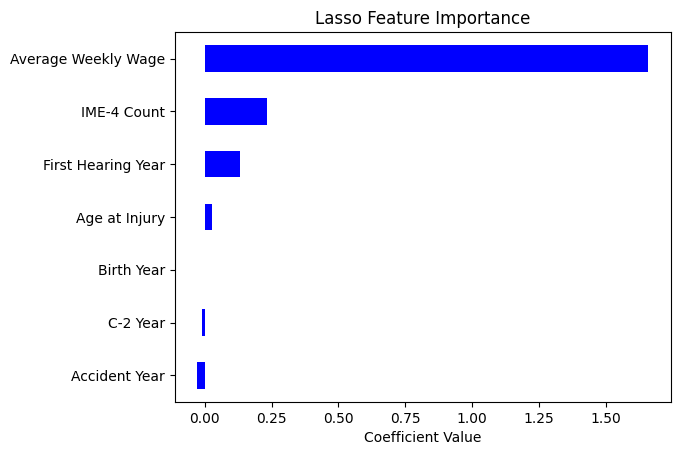

----RFE----
Trying with 15 features: 15 selected features.
Classification Report for 15 features:
              precision    recall  f1-score   support

           1       0.23      0.02      0.04      9940
           2       0.84      0.96      0.89    229355
           3       0.43      0.04      0.08     52759
           4       0.60      0.93      0.73    119120
           5       0.67      0.08      0.14     43519
           6       0.00      0.00      0.00      4006
           7       0.00      0.00      0.00        93
           8       0.00      0.00      0.00       428

    accuracy                           0.73    459220
   macro avg       0.34      0.25      0.24    459220
weighted avg       0.69      0.73      0.66    459220

----CORR----


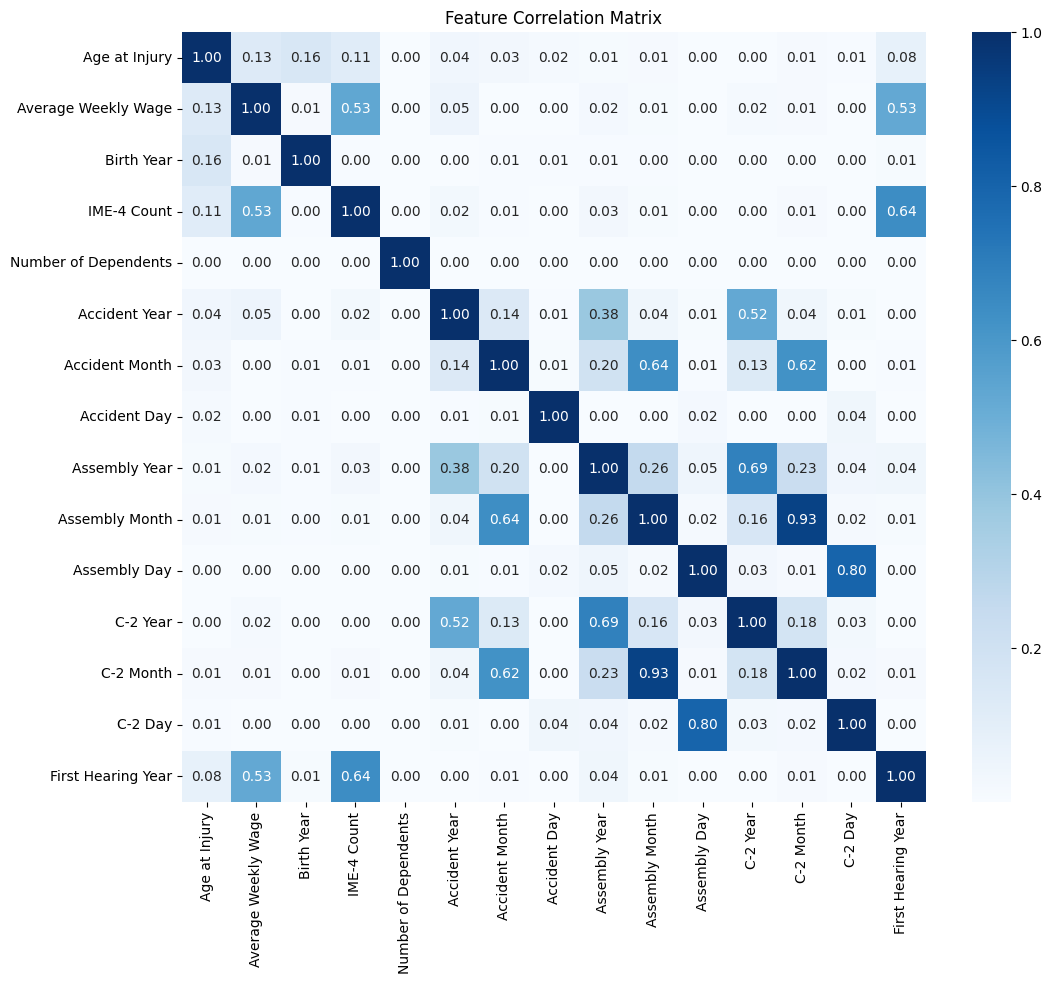

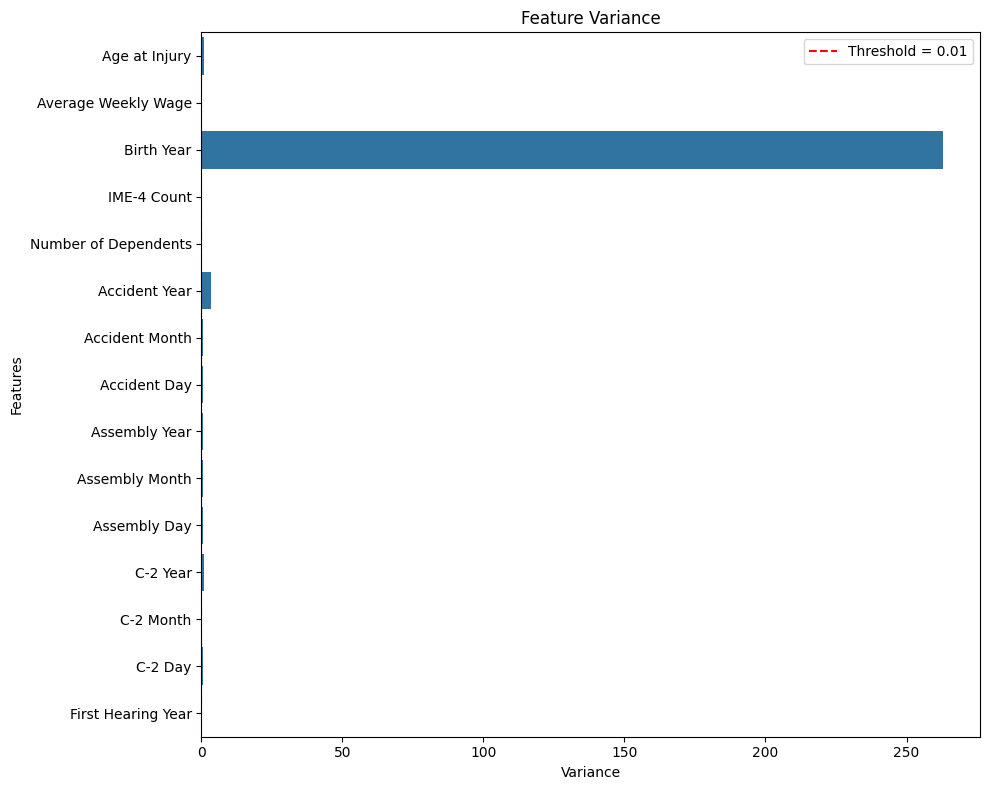

----CHI2----


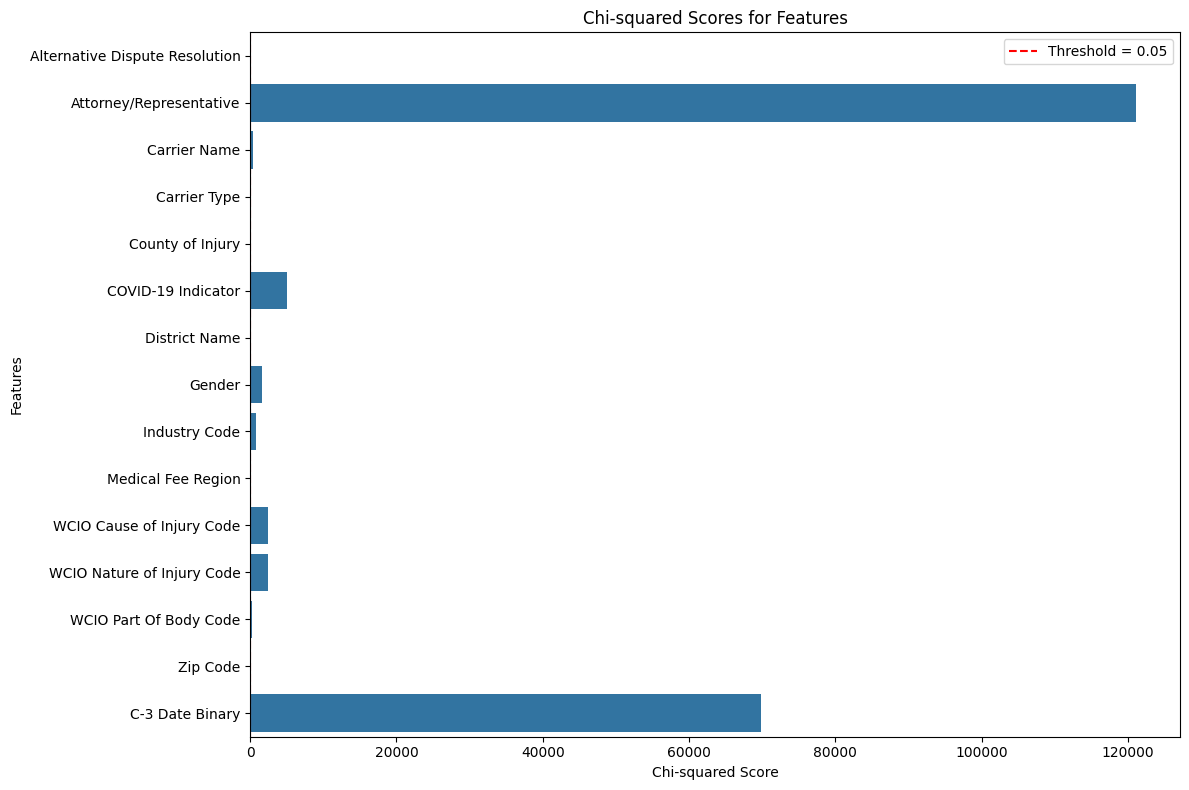

----MI----


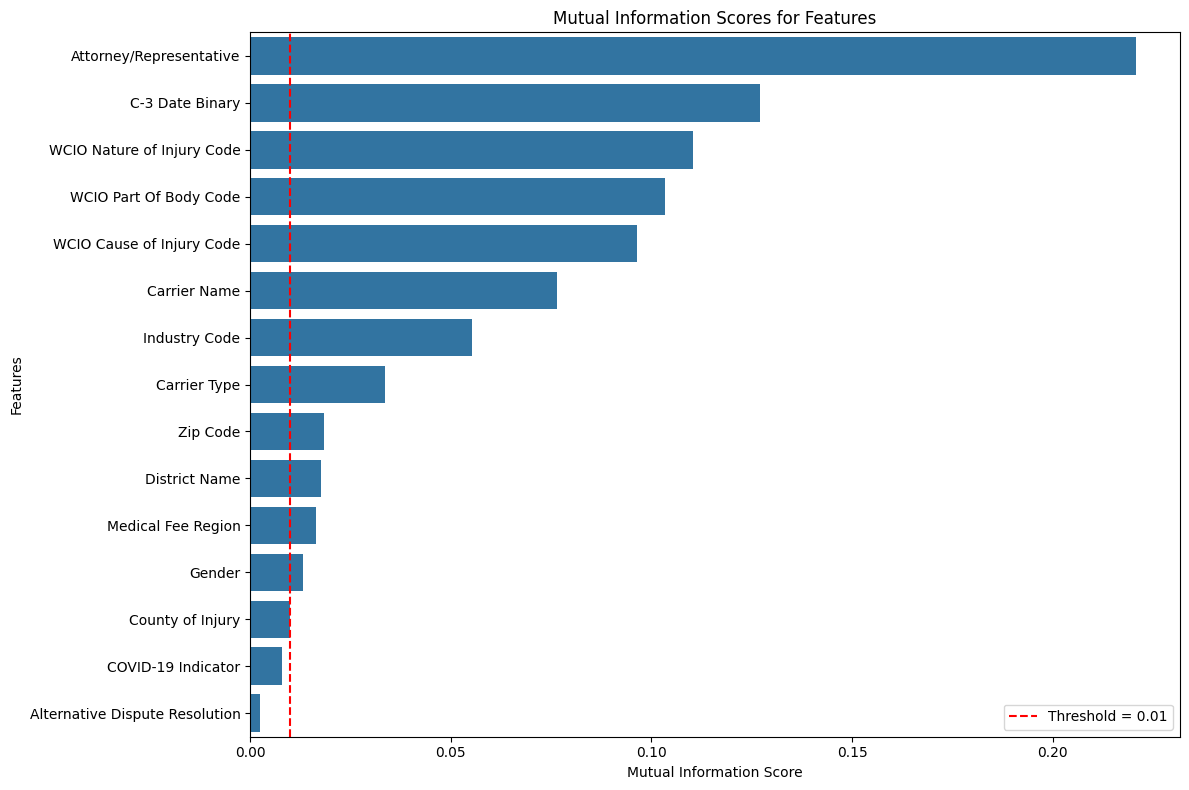

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.69      0.27      0.39      2536
           2       0.84      0.95      0.89     61723
           3       0.38      0.05      0.10     16147
           4       0.69      0.93      0.79     29387
           5       0.41      0.18      0.25      4761
           6       0.00      0.00      0.00       205
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        42

    accuracy                           0.77    114805
   macro avg       0.38      0.30      0.30    114805
weighted avg       0.71      0.77      0.71    114805

115.43604779243469


Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpqw2iahzi.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s



126.74471187591553


['C-2 Day',
 'Accident Year',
 'Birth Year',
 'Assembly Month',
 'C-2 Month',
 'Average Weekly Wage',
 'Age at Injury',
 'C-2 Year',
 'Number of Dependents',
 'Accident Day',
 'Assembly Year',
 'First Hearing Year',
 'IME-4 Count',
 'Assembly Day',
 'Accident Month',
 'WCIO Cause of Injury Code',
 'Gender',
 'COVID-19 Indicator',
 'WCIO Part Of Body Code',
 'County of Injury',
 'Attorney/Representative',
 'Carrier Type',
 'District Name',
 'Medical Fee Region',
 'Zip Code',
 'Carrier Name',
 'C-3 Date Binary',
 'Alternative Dispute Resolution',
 'WCIO Nature of Injury Code',
 'Industry Code']

In [141]:
rfe_features = [15]

evaluate_features(df, num, categ, 
                  rfe_features = rfe_features,
                  rfe_model = LogisticRegression(),
                  k = 5)

RFE n está a selecionar nenhum número de features (por enquanto), está apenas a mostrar o classification report para cada número de features inputed.

__*5 fold train: LogReg, rfe: LogReg, features=[12,13,14,15]*__

['Accident Year',
 'Number of Dependents',
 'C-2 Day',
 'Assembly Day',
 'First Hearing Year',
 'C-2 Month',
 'IME-4 Count',
 'Assembly Year',
 'Age at Injury',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Day',
 'Assembly Month',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
  TIME: 
 
 __*5 fold train: LogReg, rfe: RF, features=[12]*__
 
 ['Assembly Day',
 'Assembly Month',
 'Assembly Year',
 'First Hearing Year',
 'Age at Injury',
 'C-2 Month',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Year',
 'IME-4 Count',
 'Number of Dependents',
 'Accident Day',
 'C-2 Day',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
 TIME: 28min
 
__*2 fold train: LogReg, rfe: LogReg, features=[12] WITH FS*__

['C-2 Day',
 'Accident Year',
 'Birth Year',
 'Assembly Month',
 'C-2 Month',
 'Average Weekly Wage',
 'Age at Injury',
 'C-2 Year',
 'Number of Dependents',
 'Accident Day',
 'Assembly Year',
 'First Hearing Year',
 'IME-4 Count',
 'Assembly Day',
 'Accident Month',
 'WCIO Cause of Injury Code',
 'Gender',
 'COVID-19 Indicator',
 'WCIO Part Of Body Code',
 'County of Injury',
 'Attorney/Representative',
 'Carrier Type',
 'District Name',
 'Medical Fee Region',
 'Zip Code',
 'Carrier Name',
 'C-3 Date Binary',
 'Alternative Dispute Resolution',
 'WCIO Nature of Injury Code',
 'Industry Code']
 
  TIME:
  
__*5 fold train: LogReg, rfe: LogReg, features=[12] WITH FS*__  
  
['C-2 Day',
 'Accident Year',
 'Birth Year',
 'Assembly Month',
 'C-2 Month',
 'Average Weekly Wage',
 'Age at Injury',
 'C-2 Year',
 'Number of Dependents',
 'Accident Day',
 'Assembly Year',
 'First Hearing Year',
 'IME-4 Count',
 'Assembly Day',
 'Accident Month',
 'WCIO Cause of Injury Code',
 'Gender',
 'COVID-19 Indicator',
 'WCIO Part Of Body Code',
 'County of Injury',
 'Attorney/Representative',
 'Carrier Type',
 'District Name',
 'Medical Fee Region',
 'Zip Code',
 'Carrier Name',
 'C-3 Date Binary',
 'Alternative Dispute Resolution',
 'WCIO Nature of Injury Code',
 'Industry Code']

Numerical Features: Lasso, RFE, Variance Threshold, Correlation Matrix, Statistical Tests. <br> <BR>
Categorical Features: Chi-Squared Test, Information Gain, Tree-based Methods, Mutual Information.